## Step 1 :  Install & Import Dependencies.

In [3]:
#to access kaggle datasets
!pip install kaggle

#math operations
!pip install numpy==1.15.0

#Machine Learning
!pip install catboost


In [0]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

In [5]:
#Colab files access:
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#moving and changing permission of the files.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
#list competitions:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2559           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10275           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4056           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2560           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
aerial-c

In [8]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 14.0MB/s]
 96% 233M/242M [00:01<00:00, 176MB/s]
100% 242M/242M [00:01<00:00, 184MB/s]
100% 2.02G/2.03G [00:37<00:00, 54.6MB/s]
100% 2.03G/2.03G [00:37<00:00, 58.7MB/s]


In [6]:
!ls

sample_data	       seg_428d66.csv  seg_8472f3.csv  seg_c21d60.csv
sample_submission.csv  seg_42c4c9.csv  seg_848695.csv  seg_c22bd4.csv
seg_00030f.csv	       seg_42e7e8.csv  seg_84a65d.csv  seg_c23429.csv
seg_0012b5.csv	       seg_42ff14.csv  seg_84b9d9.csv  seg_c23641.csv
seg_00184e.csv	       seg_430e66.csv  seg_84c7fb.csv  seg_c243a6.csv
seg_003339.csv	       seg_43383f.csv  seg_84fc12.csv  seg_c24946.csv
seg_0042cc.csv	       seg_434c96.csv  seg_8509db.csv  seg_c25855.csv
seg_004314.csv	       seg_43597f.csv  seg_850d95.csv  seg_c267a5.csv
seg_004cd2.csv	       seg_43c6f4.csv  seg_8515fd.csv  seg_c26fb4.csv
seg_004ee5.csv	       seg_440106.csv  seg_853302.csv  seg_c27591.csv
seg_004f1f.csv	       seg_4401d8.csv  seg_854d91.csv  seg_c2a0c8.csv
seg_00648a.csv	       seg_441c6d.csv  seg_857304.csv  seg_c2b8f7.csv
seg_006e4a.csv	       seg_4435bd.csv  seg_85762d.csv  seg_c3507f.csv
seg_007a37.csv	       seg_447972.csv  seg_8599ec.csv  seg_c35940.csv
seg_00a37e.csv	       seg_447b8b.csv

In [10]:
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [13]:
!unzip test.zip

Archive:  test.zip
  inflating: seg_430e66.csv          
  inflating: seg_d1a281.csv          
  inflating: seg_05a1b0.csv          
  inflating: seg_f8dd7e.csv          
  inflating: seg_b9bdd7.csv          
  inflating: seg_24c1c9.csv          
  inflating: seg_c5abaa.csv          
  inflating: seg_6262c4.csv          
  inflating: seg_734a88.csv          
  inflating: seg_94a133.csv          
  inflating: seg_d0c280.csv          
  inflating: seg_d36737.csv          
  inflating: seg_f80e44.csv          
  inflating: seg_07c815.csv          
  inflating: seg_7c9433.csv          
  inflating: seg_211486.csv          
  inflating: seg_78ded2.csv          
  inflating: seg_f11f77.csv          
  inflating: seg_b3883e.csv          
  inflating: seg_3db0a8.csv          
  inflating: seg_81f798.csv          
  inflating: seg_0a45a1.csv          
  inflating: seg_dc188b.csv          
  inflating: seg_4a9e8d.csv          
  inflating: seg_32fc4e.csv          
  inflating: seg_7b2994.csv    

In [0]:
!ls -la | grep .csv

In [0]:
#Extracting Train Information into a Pandas Dataframe.
train  = pd.read_csv('train.csv', nrows=60000000, dtype={'acoustic_data': np.int16, 'time_to_failure':np.float64})

In [8]:
#printing a couple of data
train.head(15)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


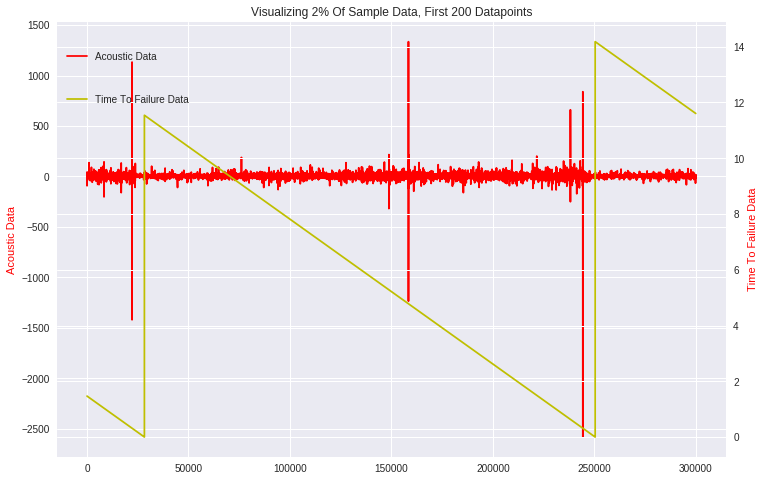

In [9]:
#visualize 2% of sample data, first 200 datapoints.
train_ad_vizsample_df = train['acoustic_data'].values[::200]
train_ttf_vizsample_df = train['time_to_failure'].values[::200]

#functionns for plotting based on based features

def plot_data(train_ad_vizsample_df, train_ttf_vizsample_df, title):
  fig, ax1 = plt.subplots(figsize=(12,8))
  plt.title(title)
  plt.plot(train_ad_vizsample_df, color='r')
  ax1.set_ylabel('Acoustic Data', color='r')
  plt.legend(['Acoustic Data'], loc=(0.01, 0.90))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_vizsample_df, color='y')
  ax2.set_ylabel('Time To Failure Data', color='r')
  plt.legend(['Time To Failure Data'], loc=(0.01, 0.80))
  plt.grid(True)
  
title = 'Visualizing 2% Of Sample Data, First 200 Datapoints'
plot_data(train_ad_vizsample_df, train_ttf_vizsample_df, title)
del train_ttf_vizsample_df
del train_ad_vizsample_df
  

In [0]:
#is the iterval constant, do ay other factors are involved using exploratory data analysis.

In [0]:
#Step 4 : Feature Engineering
#function to geerate some statistical feature based
def generate_feature(x):
  strain = []
  strain.append(x.mean())
  strain.append(x.std())
  strain.append(x.min())
  strain.append(x.kurtosis())
  strain.append(x.skew())
  strain.append(np.quantile(x, 0.01))
  return pd.Series(strain)

#x_train.describe()

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16, 'time_to_failure':np.float64})

x_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
  ch = generate_feature(df['acoustic_data'])
  x_train = x_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [24]:
x_train.describe()

,0,1,2,3,4,5
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,68.297997,0.125830,-11.224603
std,0.256049,8.503939,265.087984,70.532565,0.477901,14.106852
min,3.596313,2.802720,-5515.000000,0.648602,-4.091826,-336.000000
25%,4.349497,4.478637,-154.000000,28.090227,-0.040779,-14.000000
50%,4.522147,5.618798,-111.000000,45.816625,0.085620,-10.000000
75%,4.693350,6.880904,-79.000000,78.664202,0.253930,-6.000000
max,5.391993,153.703569,-15.000000,631.158927,4.219429,-2.000000


In [28]:
#Step 5 :  Implement CatBoost Model
train_pool = Pool(x_train,y_train)
m= CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(x_train,y_train, silent=True)

In [29]:
m.best_score_

{'learn': {'MAE': 1.8601300851030422}}